In [7]:
# Replace with your actual file ID from Google Drive
file_id = "1mPHRjDmk_yMSHBjx7T8l8bQY_2U7adIM"
output_file = "Prepared.zip"

# Download using gdown
!pip install -q gdown
!gdown --id {file_id} -O {output_file}

# Unzip
!unzip -q Prepared.zip -d /kaggle/working/Prepared
print("✅ Dataset extracted and ready to use.")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mPHRjDmk_yMSHBjx7T8l8bQY_2U7adIM
From (redirected): https://drive.google.com/uc?id=1mPHRjDmk_yMSHBjx7T8l8bQY_2U7adIM&confirm=t&uuid=38708463-3a42-4446-ae1a-ecc5d9fc2edf
To: /kaggle/working/Prepared.zip
100%|██████████████████████████████████████| 2.42G/2.42G [00:27<00:00, 88.0MB/s]
✅ Dataset extracted and ready to use.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import os
from IPython.display import FileLink
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm




# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:

base_path = "/kaggle/working/Prepared"

In [4]:

train_path = "/kaggle/working/Prepared/train"
class_counts = {}

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[class_name] = count

# Print in sorted order
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count} images")


Corn__Common_Rust: 1000 images
Corn__Gray_Leaf_Spot: 1000 images
Corn__Healthy: 1000 images
Corn__Leaf_Blight: 1000 images
Potato_Early_Blight: 1000 images
Potato_Healthy: 1000 images
Potato_Late_Blight: 1000 images
Tomato__Early_Blight: 1000 images
Tomato__Healthy: 1381 images
Tomato__Late_Blight: 1000 images
Wheat__brown_rust: 1000 images
Wheat__healthy: 1167 images
Wheat__yellow_rust: 1000 images


In [5]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    normalize
])

test_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(f"{base_path}/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(f"{base_path}/val", transform=test_val_transform)
test_dataset  = datasets.ImageFolder(f"{base_path}/test", transform=test_val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

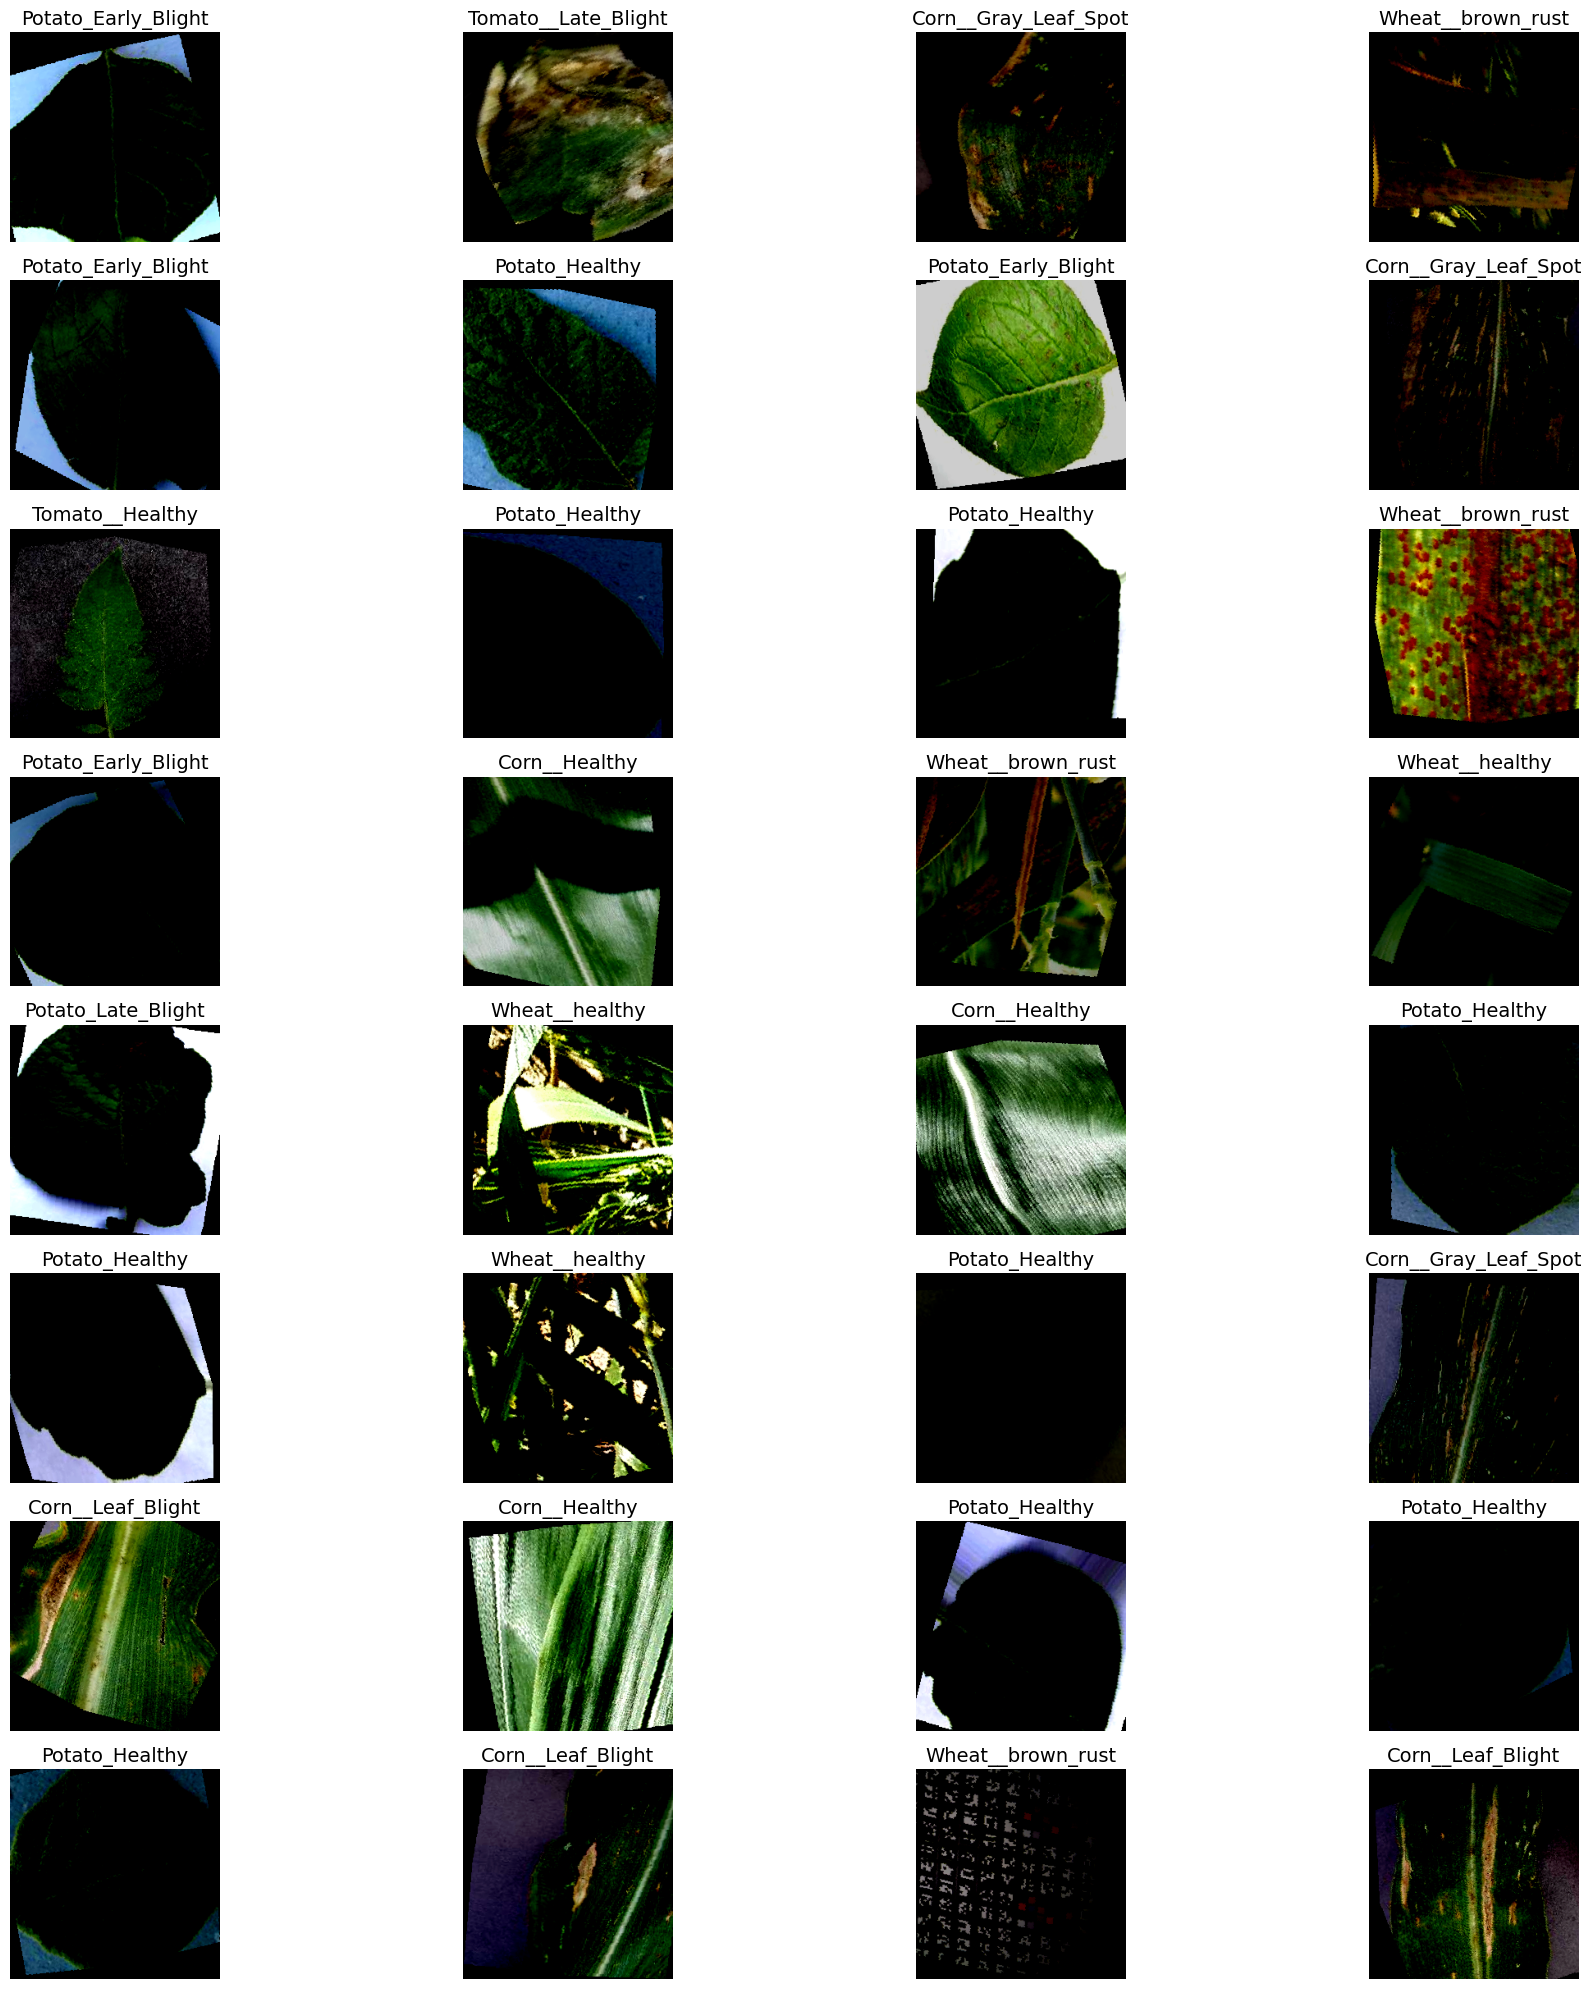

In [6]:
labels = train_dataset.classes
batch_X, batch_y = next(iter(train_loader))  

plt.figure(figsize=(20,20))
for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.imshow(batch_X[i].permute(1, 2, 0))  
    plt.axis('off')
    plt.title(f"{labels[batch_y[i].item()]}", fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
class BranchedCNN(nn.Module):
    def __init__(self, num_classes):
        super(BranchedCNN, self).__init__()

        def branch_block(kernel_size, stride):
            return nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=kernel_size, stride=stride, padding=kernel_size//2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((4, 4))
            )

        self.branch1 = branch_block(3, 1)
        self.branch2 = branch_block(5, 2)
        self.branch3 = branch_block(7, 2)

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self._init_weights()

    def forward(self, x):
        b1 = self.branch1(x).view(x.size(0), -1)
        b2 = self.branch2(x).view(x.size(0), -1)
        b3 = self.branch3(x).view(x.size(0), -1)
        out = torch.cat([b1, b2, b3], dim=1)
        return self.fc(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [10]:
model = BranchedCNN(num_classes=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model, input_size=(1, 3, 256, 256))



Layer (type:depth-idx)                   Output Shape              Param #
BranchedCNN                              [1, 13]                   --
├─Sequential: 1-1                        [1, 64, 4, 4]             --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 256, 256]         32
│    └─ReLU: 2-3                         [1, 16, 256, 256]         --
│    └─MaxPool2d: 2-4                    [1, 16, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 32, 128, 128]         4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 128, 128]         64
│    └─ReLU: 2-7                         [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-8                    [1, 32, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 64, 64, 64]           18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 64, 64]           128
│    └─ReLU: 2-11                        [1, 64, 64, 64]           --
│    └

In [11]:
epochs = 20
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    
    # -------- VALIDATION --------
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            total_val_loss += val_loss_batch.item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_loss.append(avg_val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")




Epoch 1/20 | Train Loss: 1.3076 | Val Loss: 0.8518 | Train Acc: 53.37% | Val Acc: 68.77%
Epoch 2/20 | Train Loss: 0.8996 | Val Loss: 0.5840 | Train Acc: 65.73% | Val Acc: 77.79%
Epoch 3/20 | Train Loss: 0.8175 | Val Loss: 0.6109 | Train Acc: 68.63% | Val Acc: 79.58%
Epoch 4/20 | Train Loss: 0.7271 | Val Loss: 0.6067 | Train Acc: 71.82% | Val Acc: 80.66%
Epoch 5/20 | Train Loss: 0.6897 | Val Loss: 0.5614 | Train Acc: 74.18% | Val Acc: 78.94%
Epoch 6/20 | Train Loss: 0.6523 | Val Loss: 0.4393 | Train Acc: 75.32% | Val Acc: 83.95%
Epoch 7/20 | Train Loss: 0.6123 | Val Loss: 0.4692 | Train Acc: 77.15% | Val Acc: 85.24%
Epoch 8/20 | Train Loss: 0.5747 | Val Loss: 0.5804 | Train Acc: 78.39% | Val Acc: 80.73%
Epoch 9/20 | Train Loss: 0.5530 | Val Loss: 0.4189 | Train Acc: 79.44% | Val Acc: 86.60%
Epoch 10/20 | Train Loss: 0.5325 | Val Loss: 0.3868 | Train Acc: 80.14% | Val Acc: 85.96%
Epoch 11/20 | Train Loss: 0.5045 | Val Loss: 0.4345 | Train Acc: 80.99% | Val Acc: 86.96%
Epoch 12/20 | Train

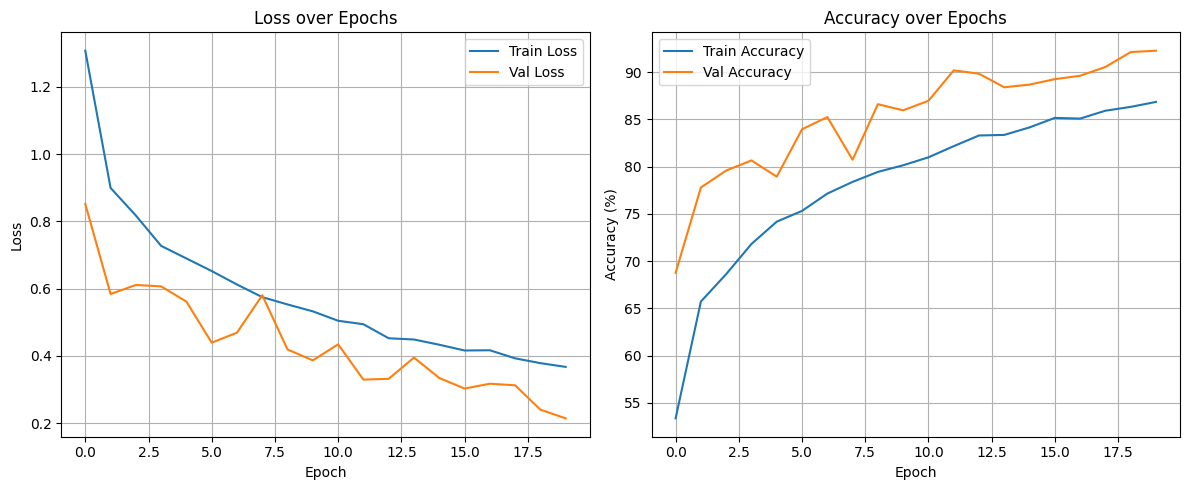

In [12]:
# ------- 📊 Plot Loss -------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', )
plt.plot(val_loss, label='Val Loss', )
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------- 📊 Plot Accuracy -------
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', )
plt.plot(val_acc, label='Val Accuracy', )
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Training Accuracy: {100 * correct / total:.2f}%")

# Save model
# torch.save(model.state_dict(), "potato_cnn.pth")


Training Accuracy: 92.10%


In [14]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Val Accuracy: {100 * correct / total:.2f}%")

# Save model
# torch.save(model.state_dict(), "potato_cnn.pth")


Val Accuracy: 92.26%


In [15]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Testing Accuracy: {100 * correct / total:.2f}%")

# Save model
# torch.save(model.state_dict(), "potato_cnn.pth")


Testing Accuracy: 91.31%


In [35]:
torch.save(model.state_dict(), 'TheHulkNet.pth')



In [9]:
classes =['Corn__Common_Rust',
 'Corn__Gray_Leaf_Spot',
 'Corn__Healthy',
 'Corn__Leaf_Blight',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_Blight',
 'Tomato__Early_Blight',
 'Tomato__Healthy',
 'Tomato__Late_Blight',
 'Wheat__brown_rust',
 'Wheat__healthy',
 'Wheat__yellow_rust']

In [10]:
model = BranchedCNN(num_classes=13)
model.load_state_dict(torch.load('/kaggle/input/thehulknet/pytorch/default/1/TheHulkNet.pth', map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim and move to device

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()


In [19]:

image_path = '/kaggle/input/crops-disease/Data/Potato_Early_Blight/Early_Blight_1000.jpg'  # your test image path here
predicted_class = predict_image(image_path)
print(f"Predicted class: {classes[predicted_class]}")
print(f"Predicted class index: {predicted_class}")

Predicted class: Potato_Early_Blight
Predicted class index: 4


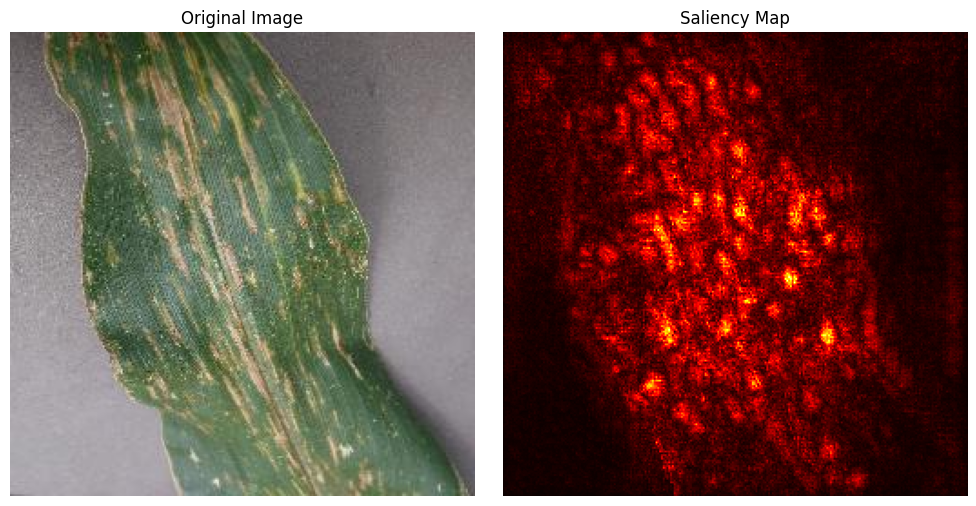

In [18]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]
input_tensor.requires_grad_()  # VERY IMPORTANT!

# Model inference
model.eval()
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backprop to get saliency
model.zero_grad()
score = output[0, predicted_class]
score.backward()

# Get absolute gradient (saliency)
saliency = input_tensor.grad.data.abs().squeeze().cpu()  # [3, H, W]
saliency, _ = torch.max(saliency, dim=0)  # [H, W]

# Inverse normalization
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

original_img = inv_normalize(input_tensor[0].cpu())
original_img = original_img.permute(1, 2, 0).clamp(0, 1)

# 🔥 Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img.detach().numpy())
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency.numpy(), cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

plt.tight_layout()
plt.show()


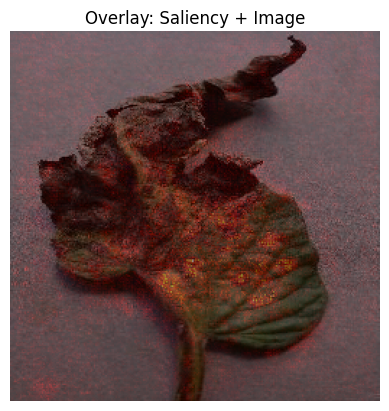

In [34]:

saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min())
saliency_color = plt.cm.hot(saliency_norm.numpy())[:, :, :3]  # Remove alpha channel

# Convert original image to numpy
orig_np = original_img.detach().numpy()

# Overlay with transparency
overlay = 0.6 * orig_np + 0.4 * saliency_color
overlay = np.clip(overlay, 0, 1)

plt.imshow(overlay)
plt.title("Overlay: Saliency + Image")
plt.axis('off')
plt.show()


In [36]:
class_names = train_dataset.classes
class_names

['Corn__Common_Rust',
 'Corn__Gray_Leaf_Spot',
 'Corn__Healthy',
 'Corn__Leaf_Blight',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_Blight',
 'Tomato__Early_Blight',
 'Tomato__Healthy',
 'Tomato__Late_Blight',
 'Wheat__brown_rust',
 'Wheat__healthy',
 'Wheat__yellow_rust']

100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


📋 Classification Report:

                      precision    recall  f1-score   support

   Corn__Common_Rust       0.99      0.85      0.91       100
Corn__Gray_Leaf_Spot       0.85      0.76      0.80       100
       Corn__Healthy       1.00      1.00      1.00       100
   Corn__Leaf_Blight       0.76      0.83      0.79       100
 Potato_Early_Blight       0.96      0.90      0.93       100
      Potato_Healthy       0.90      0.97      0.93       100
  Potato_Late_Blight       0.96      0.94      0.95       100
Tomato__Early_Blight       0.89      0.85      0.87       100
     Tomato__Healthy       0.94      1.00      0.97       192
 Tomato__Late_Blight       0.86      0.83      0.85       100
   Wheat__brown_rust       0.97      0.90      0.93       100
      Wheat__healthy       0.91      0.96      0.94       100
  Wheat__yellow_rust       0.87      1.00      0.93       100

            accuracy                           0.91      1392
           macro avg       0.91      0.91 

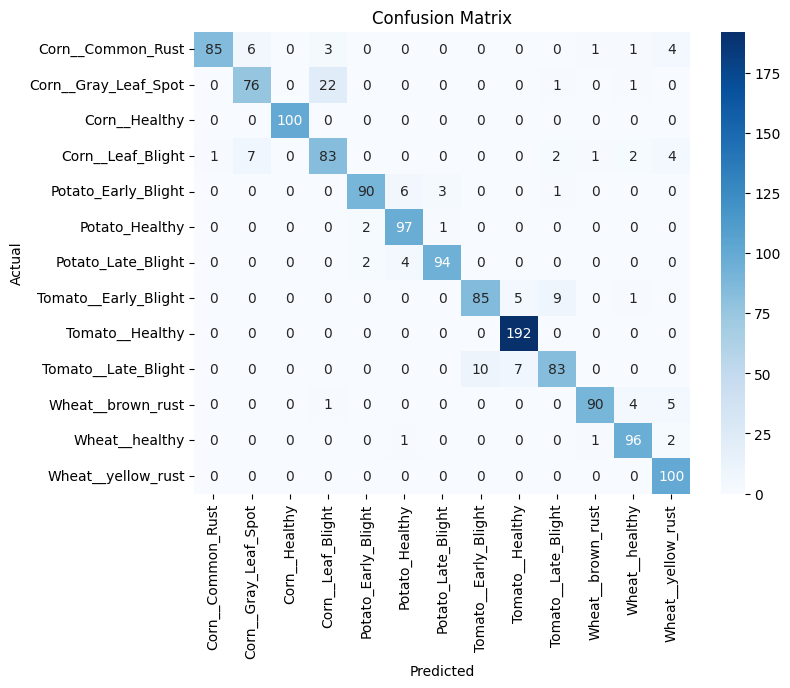

In [16]:

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [35]:

print(cm)

[[ 87   2   0   4   0   0   0   0   0   2   4   0   1]
 [  1  79   0  17   0   0   0   0   0   0   2   1   0]
 [  0   0 100   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0  80   0   0   0   0   0   2   3   7   2]
 [  0   0   0   0  85   2  13   0   0   0   0   0   0]
 [  0   0   0   0   7  84   9   0   0   0   0   0   0]
 [  0   0   0   0  10   4  86   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  78   0  20   1   0   0]
 [  0   0   0   0   0   0   0   0 192   0   0   0   0]
 [  0   0   0   2   0   1   0   0   2  94   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0  94   1   5]
 [  0   0   0   1   0   0   0   0   0   0   1  94   4]
 [  0   0   0   0   0   0   0   0   0   0   5   3  92]]
